### Classification 

In [11]:
# Manipulation de données et calculs
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Datasets et Réduction de dimension
from sklearn.datasets import load_iris
from sklearn.manifold import TSNE

# Préparation et Validation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# Modèles de Classification
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Métriques d'évaluation
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve, 
    accuracy_score, 
    f1_score
)

In [12]:
df = pd.read_csv("dataset/cleaned_datasetclusters.csv")

In [13]:
def preparer_donnees_classification(df, target_column='Churn', test_size=0.2, random_state=42, keep_cluster=False):
    # Préparation de la liste des colonnes à supprimer
    del_cols = [target_column]
    
    # Correction syntaxe : on utilise 'not' et on vérifie si la colonne existe
    if not keep_cluster and "Cluster" in df.columns: 
        del_cols.append("Cluster")
    
    # Séparation Features / Target
    X = df.drop(columns=del_cols)
    y = df[target_column]
    
    # Split des données
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Standardisation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [14]:
X_train, X_test, y_train, y_test = preparer_donnees_classification(df, keep_cluster=False)

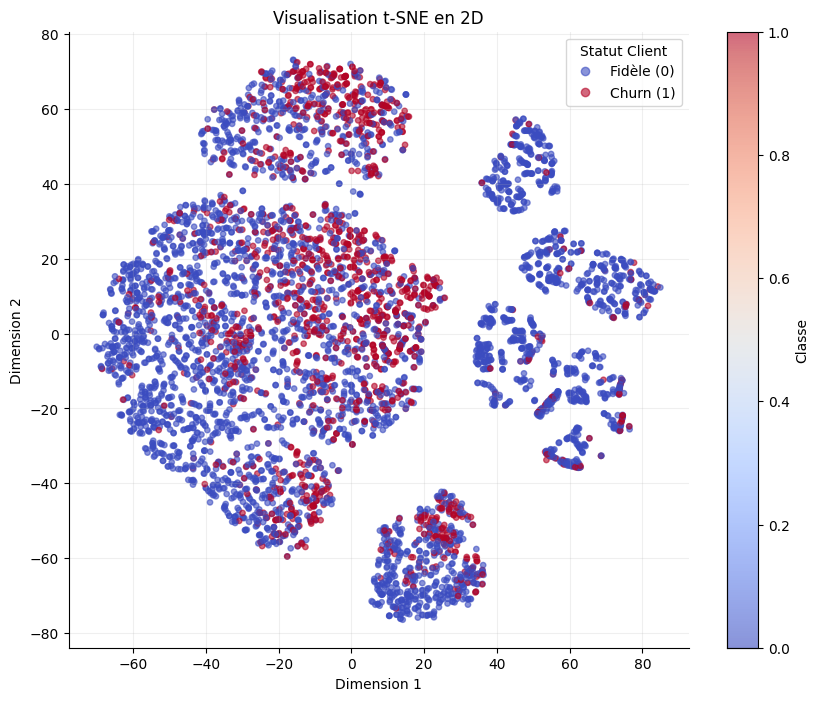

In [23]:
# Visualisation en utilisant t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    random_state=42,
    init='pca',
    learning_rate='auto'
)
X_tsne = tsne.fit_transform(X_train)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap="coolwarm", s=15,alpha=0.6)
handles, labels = scatter.legend_elements()
plt.legend(handles, ["Fidèle (0)", "Churn (1)"], loc="upper right", title="Statut Client")
plt.colorbar(scatter, label="Classe")
plt.title("Visualisation t-SNE en 2D")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
sns.despine() # Supprime les bordures haut et droite
plt.grid(alpha=0.2) # Ajoute un quadrillage léger
plt.show()


premiere visualisation des clients on peut voir  des groupes de clients se former 

### Grid Search 

on met class_weight balanced pour réequilibrer churn 

In [24]:
param_grids = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'max_depth': [None, 5, 10, 20]}
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'C': [0.1, 1, 10]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'n_estimators': [50, 100], 'max_depth': [None, 10]}
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'C': [0.1, 1, 10], 'kernel': ['rbf']}
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42, verbose=-1, is_unbalance=True), # AJOUTÉ
        "params": {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
    },
    "XGBoost": {
        # Pour XGBoost, on utilise scale_pos_weight (Ratio Majoritaire/Minoritaire = 80/20 = 4)
        "model": XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=4), # AJOUTÉ
        "params": {'n_estimators': [100, 200], 'max_depth': [3, 6]}
    },
        "Gaussian NB": {
        "model": GaussianNB(),
        "params": {} # Pas d'hyperparamètres majeurs à tuner
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            'n_estimators': [50, 100],
            'learning_rate': [0.1, 1.0]
        }
    }
}

best_estimators = {}

for name, config in param_grids.items():
    print(f"Optimisation de {name}...")
    grid = GridSearchCV(config["model"], config["params"], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_estimators[name] = grid.best_estimator_
    print(f"Meilleurs paramètres : {grid.best_params_}")

Optimisation de KNN...
Meilleurs paramètres : {'n_neighbors': 9, 'weights': 'uniform'}
Optimisation de Decision Tree...
Meilleurs paramètres : {'max_depth': 5}
Optimisation de Logistic Regression...
Meilleurs paramètres : {'C': 1}
Optimisation de Random Forest...
Meilleurs paramètres : {'max_depth': 10, 'n_estimators': 100}
Optimisation de SVM...
Meilleurs paramètres : {'C': 0.1, 'kernel': 'rbf'}
Optimisation de LightGBM...
Meilleurs paramètres : {'learning_rate': 0.01, 'n_estimators': 200}
Optimisation de XGBoost...
Meilleurs paramètres : {'max_depth': 3, 'n_estimators': 100}
Optimisation de Gaussian NB...
Meilleurs paramètres : {}
Optimisation de AdaBoost...
Meilleurs paramètres : {'learning_rate': 1.0, 'n_estimators': 50}


### stacking and boosting 

In [26]:
# On sélectionne les 3 meilleurs modèles qui ne sont pas deja booster ou stacke
estimators_list = [
    ('rf', best_estimators["Random Forest"]),
    ('svc', best_estimators["SVM"]),
    ('lr', best_estimators["Logistic Regression"])
]

# Voting Classifier
voting_clf = VotingClassifier(estimators=estimators_list, voting='soft')
voting_clf.fit(X_train, y_train)
best_estimators["Voting"] = voting_clf

# Stacking Classifier
stacking_clf = StackingClassifier(estimators=estimators_list, final_estimator=LogisticRegression())
stacking_clf.fit(X_train, y_train)
best_estimators["Stacking"] = stacking_clf


Évaluation des modèles sur le set de test...


C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- TABLEAU COMPARATIF DES PERFORMANCES ---
             Modèle  Accuracy  F1-Score    AUC
           LightGBM    0.7679    0.6363 0.8447
      Decision Tree    0.7544    0.6311 0.8367
             Voting    0.7722    0.6246 0.8417
Logistic Regression    0.7410    0.6210 0.8405
      Random Forest    0.7693    0.6208 0.8413
            XGBoost    0.7296    0.6201 0.8293
           Stacking    0.8013    0.6067 0.8443
                SVM    0.7225    0.6022 0.8270
           AdaBoost    0.7899    0.5723 0.8373
        Gaussian NB    0.6515    0.5697 0.8085
                KNN    0.7615    0.5410 0.7810


C:\Users\sppre\AppData\Local\Temp\ipykernel_27780\2530344616.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="F1-Score", y="Modèle", data=df_comparaison, palette="magma")


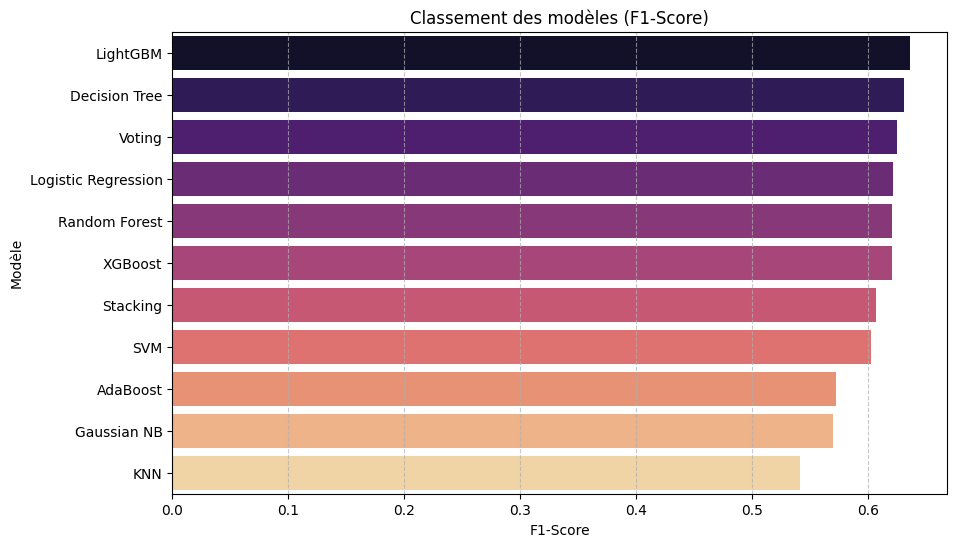

In [27]:
# 1. Création d'une liste pour stocker les scores
resultats_liste = []

print("\nÉvaluation des modèles sur le set de test...")

for name, model in best_estimators.items():
    # Prédiction
    y_pred = model.predict(X_test)
    
    # Calcul des probabilités pour l'AUC (si le modèle le permet)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = "N/A" # Pour les modèles qui n'ont pas predict_proba
        
    # Calcul des métriques
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Ajout dans la liste
    resultats_liste.append({
        "Modèle": name,
        "Accuracy": round(acc, 4),
        "F1-Score": round(f1, 4),
        "AUC": round(auc, 4) if isinstance(auc, float) else auc
    })

# 2. Transformation de la liste en DataFrame Pandas pour un affichage propre
df_comparaison = pd.DataFrame(resultats_liste)

# 3. Tri par F1-Score (le plus important pour ton cas de Churn)
df_comparaison = df_comparaison.sort_values(by="F1-Score", ascending=False)

# 4. Affichage du tableau final
print("\n--- TABLEAU COMPARATIF DES PERFORMANCES ---")
print(df_comparaison.to_string(index=False))

# 5. Visualisation graphique du F1-Score
plt.figure(figsize=(10, 6))
sns.barplot(x="F1-Score", y="Modèle", data=df_comparaison, palette="magma")
plt.title("Classement des modèles (F1-Score)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


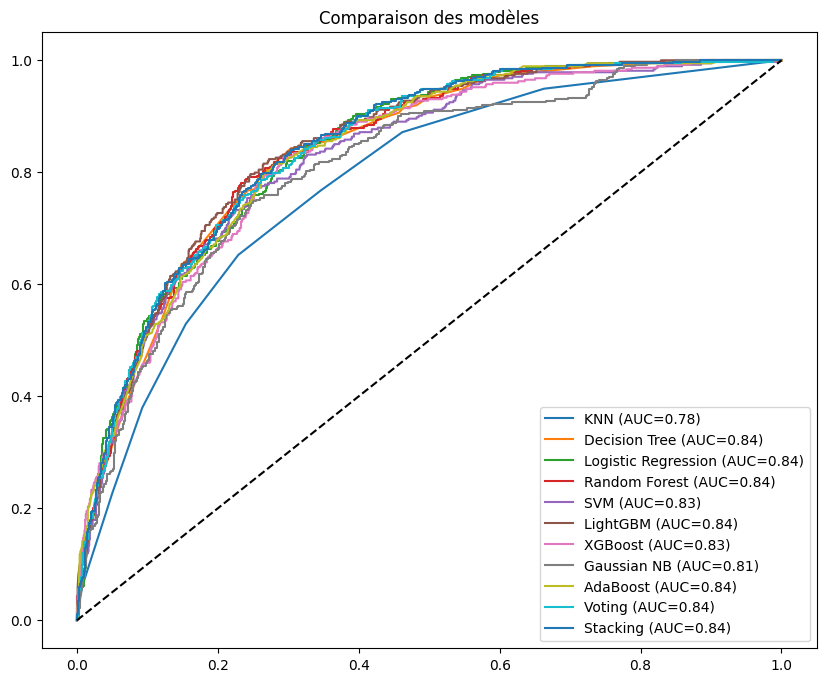

                 Modèle  Accuracy  F1-Score       AUC
5              LightGBM  0.767921  0.636263  0.844660
1         Decision Tree  0.754436  0.631130  0.836678
9                Voting  0.772179  0.624561  0.841672
2   Logistic Regression  0.740951  0.620976  0.840518
3         Random Forest  0.769340  0.620770  0.841272
6               XGBoost  0.729595  0.620140  0.829333
10             Stacking  0.801278  0.606742  0.844349
4                   SVM  0.722498  0.602238  0.826963
8              AdaBoost  0.789922  0.572254  0.837336
7           Gaussian NB  0.651526  0.569676  0.808507
0                   KNN  0.761533  0.540984  0.780984


In [28]:
def evaluer_tous_les_modeles(dict_modeles, X_test, y_test):
    resultats = []
    plt.figure(figsize=(10, 8))
    
    for nom, modele in dict_modeles.items():
        y_pred = modele.predict(X_test)
        y_prob = modele.predict_proba(X_test)[:, 1] if hasattr(modele, "predict_proba") else y_pred
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        
        resultats.append({"Modèle": nom, "Accuracy": acc, "F1-Score": f1, "AUC": auc})
        
        # Courbe ROC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{nom} (AUC={auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend()
    plt.title("Comparaison des modèles")
    plt.show()
    
    return pd.DataFrame(resultats).sort_values(by="F1-Score", ascending=False)

df_perf = evaluer_tous_les_modeles(best_estimators, X_test, y_test)
print(df_perf)